In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_AC_postLL1_57to62keV/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_DC_postLL1_57to62keV/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE_path = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

sim_dCCE = np.loadtxt(sim_dCCE_path, delimiter=',').T
depth_grid = sim_dCCE[0]

### In these, b=electron trapping, c=hole trapping
def e_cce(b, c):
    ### electron-dominated signal
    return (1.-b*sim_dCCE[1][::-1])*(1.-c*sim_dCCE[2][::-1])
def h_cce(b, c):
    ### hole-dominated signal
    return (1.-b*sim_dCCE[3][::-1])*(1.-c*sim_dCCE[4][::-1])

etrap_map = np.zeros((37,37))
htrap_map = np.zeros((37,37))
with open('/home/cosilab/COSITrapping/UCSDdet_trappingprodmap.txt', 'r') as file:
    for line in file:
        splitline = line.split(' ')
        p = int(splitline[1])
        n = int(splitline[3])
        etrap_map[p,n] = float(splitline[4])
        htrap_map[p,n] = float(splitline[5])
# print(etrap_map)

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat'], \
                       ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']], \
            'Ba133': [['20231113_Ba133_AC_600V.dat', '20231114_Ba133_AC_600V.dat', '20231115_Ba133_AC_600V.dat'], \
                      ['20231113_Ba133_DC_600V_1.dat', '20231113_Ba133_DC_600V_2.dat', '20231114_Ba133_DC_600V.dat', '20231115_Ba133_DC_600V.dat']], \
            'Na22': [['20231106_Na22_AC_600V.dat', '20231108_Na22_AC_600V.dat', '20231109_Na22_AC_600V_2.dat', '20231107_Na22_AC_600V.dat', '20231109_Na22_AC_600V_1.dat'], \
                     ['20231106_Na22_DC_600V_1.dat', '20231107_Na22_DC_600V_1.dat', '20231107_Na22_DC_600V.dat', '20231109_Na22_DC_600V.dat', \
                      '20231106_Na22_DC_600V_2.dat', '20231107_Na22_DC_600V_2.dat', '20231108_Na22_DC_600V.dat']], \
            'Am241': [['20231103_Am241_AC_600V.dat', '20231109_Am241_AC_600V.dat'], \
                      ['20231103_Am241_DC_600V_1.dat', '20231108_Am241_DC_600V_1.dat', '20231103_Am241_DC_600V_2.dat', '20231108_Am241_DC_600V_2.dat']]}

erange_dict = {'Cs137': [630., 669.], 'Ba133': [330., 360.], 'Na22': [1220., 1280.], 'Am241': [50., 64.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Ba133': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Na22': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Am241': np.linspace(calibrator.zmin, calibrator.zmax, 31)}

# Loop and make depth-calibrated dataframes

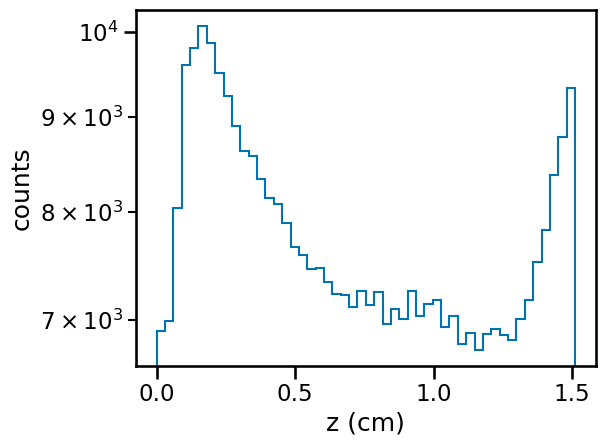

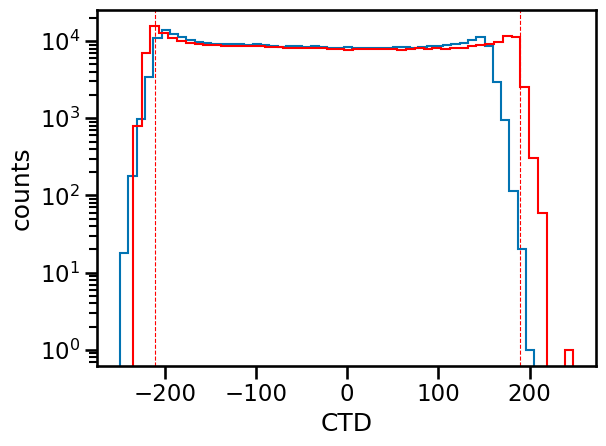

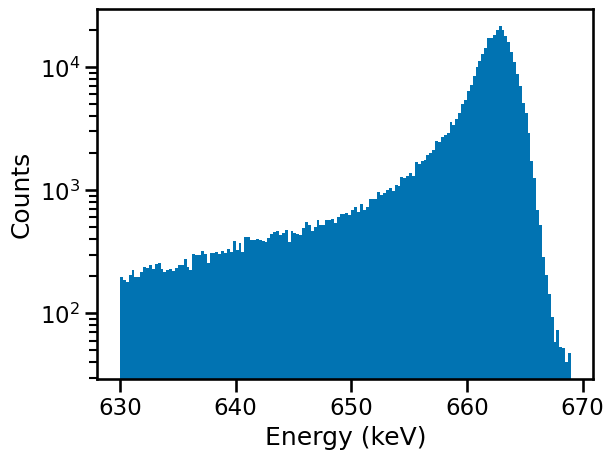

FWHM = 3.11
FWTM = 8.36


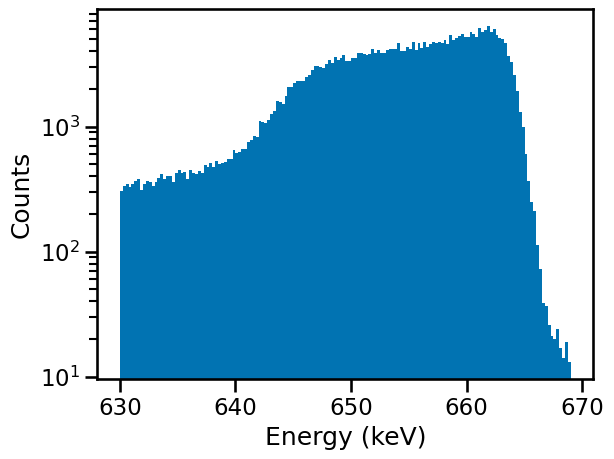

FWHM = 16.03
FWTM = 25.28


In [4]:
data_dict = {}
# for source in file_dict:
for source in ['Cs137']:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allACDC_postLL1'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.show()
    # plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.show()
    # plt.savefig(plot_dir + "CTD_" + string + ".pdf")
    
    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'][~df['bad'].values], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm, fwtm = get_FWHM_FWTM(binedges[:-1], hist)
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'][~df['bad'].values], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm, fwtm = get_FWHM_FWTM(binedges[:-1], hist)
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))


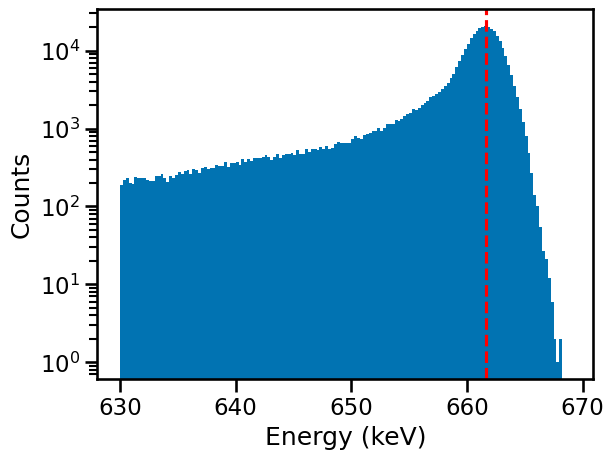

FWHM = 3.35
FWTM = 8.32


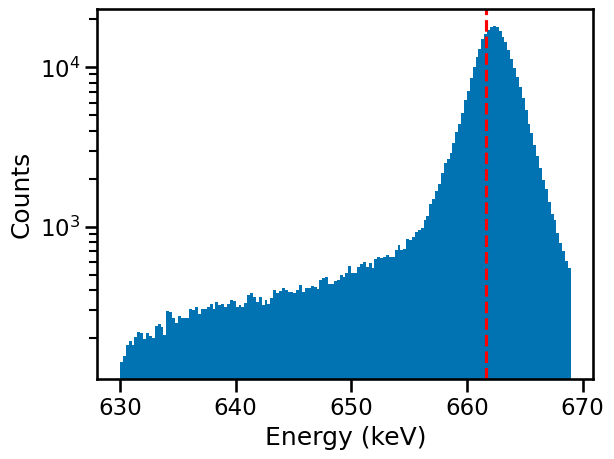

FWHM = 3.84
FWTM = 9.21


In [27]:
# for source in file_dict:
for source in ['Cs137']:
    
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]

    string = source + 'allACDC_postLL1'
    
    df = data_dict[source]
    
    for p in range(37):
        for n in range(37):
            En_z = UnivariateSpline(depth_grid, 1.00346*h_cce(etrap_map[p,n], htrap_map[p,n]))
            Ep_z = UnivariateSpline(depth_grid, 1.004315*e_cce(etrap_map[p,n], htrap_map[p,n]))

            depth = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z']
            energy_p = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p']
            energy_n = df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n']
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'depth_corrected_energy_p'] =  energy_p/Ep_z(depth)
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'depth_corrected_energy_n'] =  energy_n/En_z(depth)

    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['depth_corrected_energy_p'][~df['bad'].values], bins=bins, range=(emin, emax))
    plt.axvline(source_dict[source], color='red', ls='dashed')
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm, fwtm = get_FWHM_FWTM(binedges[:-1], hist)
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['depth_corrected_energy_n'][~df['bad'].values], bins=binedges)
    plt.axvline(source_dict[source], color='red', ls='dashed')
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm, fwtm = get_FWHM_FWTM(binedges[:-1], hist)
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))
